In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3326830813408167482
]


In [2]:
import numpy as np
import pandas as pd
import nltk
import string
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import RegexpTokenizer

##### Comments 
##### Each Methods is used and stored in series just to keep track of transition we can omit to make it for optimization
##### Also Lots of methods hasn't been modularized and  divided 
##### Generators were identified for faster execution
##### GPU hasn't able to used for Deep Learning due to dependencies also tensorflow with Cuda 11.0 and with win10 

##### Word Embedding, Joint Intent Classification, slot filing can be further implemented   

In [3]:

stop_words=stopwords.words('english')
rem_words = Counter(stop_words)
# rem_words



In [8]:
train_txt_data=pd.read_csv('./dataset/train.csv')
test_txt_data=pd.read_csv('./dataset/test.csv')
# string.punctuation
train_txt_data['comment_text']=train_txt_data['comment_text'].str.lower()

In [9]:
train_txt_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::and for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself \n\nthat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"spitzer \n\numm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [10]:
test_txt_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [11]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    text = re.sub("([^\x00-\x7F])+"," ",rem_num)
    
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
#     tokenizer = RegexpTokenizer(r'\w+')
#     tokens = tokenizer.tokenize(sentence)  
    return sentence
#     return " ".join(tokens)
train_txt_data['clean']=train_txt_data['comment_text'].map(lambda s:preprocess(s)) 


In [ ]:
# test_txt_data['clean']=test_txt_data['comment_text'].map(lambda s:preprocess(s)) 


In [12]:
train_txt_data['clean']

0         explanation\nwhy the edits made under my usern...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         "\nmore can't make any real suggestions on imp...
4         you, sir, are my hero. any chance you remember...
                                ...                        
159566    ":::::and for the second time of asking, when ...
159567    you should be ashamed of yourself \n\nthat is ...
159568    spitzer \n\numm, theres no actual article for ...
159569    and it looks like it was actually you who put ...
159570    "\nand ... really don't think you understand. ...
Name: clean, Length: 159571, dtype: object

In [13]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '',string.punctuation))

######## tokenizers
def tokenize(text):
    tokens=regexp_tokenize(text,pattern='\s+',gaps=True) #https://towardsdatascience.com/benchmarking-python-nlp-tokenizers-3ac4735100c5
    return(tokens)   


    

In [26]:
###punctuation removal
train_txt_data['clean']=train_txt_data['clean'].apply(remove_punctuation)
train_txt_data['clean']

0         explanation\nwhy the edits made under my usern...
1         daww he matches this background colour im seem...
2         hey man im really not trying to edit war its j...
3         \nmore cant make any real suggestions on impro...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself \n\nthat is ...
159568    spitzer \n\numm theres no actual article for p...
159569    and it looks like it was actually you who put ...
159570    \nand  really dont think you understand came h...
Name: clean, Length: 159571, dtype: object

In [15]:
### tokenize
train_txt_data['comment_text_tokens']=train_txt_data['clean'].apply(tokenize)
train_txt_data['comment_text_tokens']

0         [explanation, why, the, edits, made, under, my...
1         [daww, he, matches, this, background, colour, ...
2         [hey, man, im, really, not, trying, to, edit, ...
3         [more, cant, make, any, real, suggestions, on,...
4         [you, sir, are, my, hero, any, chance, you, re...
                                ...                        
159566    [and, for, the, second, time, of, asking, when...
159567    [you, should, be, ashamed, of, yourself, that,...
159568    [spitzer, umm, theres, no, actual, article, fo...
159569    [and, it, looks, like, it, was, actually, you,...
159570    [and, really, dont, think, you, understand, ca...
Name: comment_text_tokens, Length: 159571, dtype: object

In [16]:
## stopwords
train_txt_data['comment_text_tokens']=train_txt_data['comment_text_tokens'].apply(lambda x:[token for token in x if token not in rem_words])
train_txt_data['comment_text_tokens']

0         [explanation, edits, made, username, hardcore,...
1         [daww, matches, background, colour, im, seemin...
2         [hey, man, im, really, trying, edit, war, guy,...
3         [cant, make, real, suggestions, improvement, w...
4                [sir, hero, chance, remember, page, thats]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567          [ashamed, horrible, thing, put, talk, page]
159568    [spitzer, umm, theres, actual, article, prosti...
159569    [looks, like, actually, put, speedy, first, ve...
159570    [really, dont, think, understand, came, idea, ...
Name: comment_text_tokens, Length: 159571, dtype: object

In [17]:
train_txt_data['comment_text_sent_clean']=train_txt_data['comment_text_tokens'].apply(lambda x:' '.join(token for token in x))
train_txt_data['comment_text_sent_clean']

0         explanation edits made username hardcore metal...
1         daww matches background colour im seemingly st...
2         hey man im really trying edit war guy constant...
3         cant make real suggestions improvement wondere...
4                       sir hero chance remember page thats
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really dont think understand came idea bad rig...
Name: comment_text_sent_clean, Length: 159571, dtype: object

In [18]:
train_txt_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,comment_text_tokens,comment_text_sent_clean
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,...",explanation edits made username hardcore metal...
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...,"[daww, matches, background, colour, im, seemin...",daww matches background colour im seemingly st...
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,hey man im really not trying to edit war its j...,"[hey, man, im, really, trying, edit, war, guy,...",hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,\nmore cant make any real suggestions on impro...,"[cant, make, real, suggestions, improvement, w...",cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page, thats]",sir hero chance remember page thats
...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::and for the second time of asking, when ...",0,0,0,0,0,0,and for the second time of asking when your vi...,"[second, time, asking, view, completely, contr...",second time asking view completely contradicts...
159567,ffea4adeee384e90,you should be ashamed of yourself \n\nthat is ...,0,0,0,0,0,0,you should be ashamed of yourself \n\nthat is ...,"[ashamed, horrible, thing, put, talk, page]",ashamed horrible thing put talk page
159568,ffee36eab5c267c9,"spitzer \n\numm, theres no actual article for ...",0,0,0,0,0,0,spitzer \n\numm theres no actual article for p...,"[spitzer, umm, theres, actual, article, prosti...",spitzer umm theres actual article prostitution...
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0,and it looks like it was actually you who put ...,"[looks, like, actually, put, speedy, first, ve...",looks like actually put speedy first version d...


In [19]:
train_txt_data['comment_text_tokens']

0         [explanation, edits, made, username, hardcore,...
1         [daww, matches, background, colour, im, seemin...
2         [hey, man, im, really, trying, edit, war, guy,...
3         [cant, make, real, suggestions, improvement, w...
4                [sir, hero, chance, remember, page, thats]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567          [ashamed, horrible, thing, put, talk, page]
159568    [spitzer, umm, theres, actual, article, prosti...
159569    [looks, like, actually, put, speedy, first, ve...
159570    [really, dont, think, understand, came, idea, ...
Name: comment_text_tokens, Length: 159571, dtype: object

In [23]:

# def lemmatize_tokens(text):
#     return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
# train_txt_data['Lemmatized tokens']=train_txt_data['comment_text_sent_clean'].apply(lemmatize_tokens)

In [25]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))

train_txt_data['Lemmatized text']=train_txt_data['comment_text_sent_clean'].apply(lemmatize_text)


In [27]:
train_txt_data['Lemmatized text']

0         explanation edits made username hardcore metal...
1         daww match background colour im seemingly stuc...
2         hey man im really trying edit war guy constant...
3         cant make real suggestion improvement wondered...
4                       sir hero chance remember page thats
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm there actual article prostitution ...
159569    look like actually put speedy first version de...
159570    really dont think understand came idea bad rig...
Name: Lemmatized text, Length: 159571, dtype: object

In [ ]:
train_txt_data.to_csv('./Process_Train_data.csv')

In [28]:
train_txt_data['comment_text_sent_clean']

0         explanation edits made username hardcore metal...
1         daww matches background colour im seemingly st...
2         hey man im really trying edit war guy constant...
3         cant make real suggestions improvement wondere...
4                       sir hero chance remember page thats
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really dont think understand came idea bad rig...
Name: comment_text_sent_clean, Length: 159571, dtype: object

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer

tfv = TfidfVectorizer(min_df=10,  max_features=30, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


In [66]:
# corpus_clean=train_txt_data['comment_text_tokens'].apply(lambda x:' '.join(token for token in x))

In [67]:
# corpus_clean

In [30]:
tfv.fit(train_txt_data['Lemmatized text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30,
                min_df=10, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [31]:
features = np.array(tfv.get_feature_names())
features

array(['article talk', 'ask question', 'blocked editing',
       'criterion speedy', 'deletion article', 'dont know', 'dont think',
       'edit page', 'edit summary', 'fair use', 'feel free', 'fuck fuck',
       'good faith', 'im sure', 'ip address', 'let know', 'lol lol',
       'look like', 'need help', 'nigger nigger', 'personal attack',
       'point view', 'reliable source', 'speedy deletion',
       'talk contribs', 'talk page', 'use sandbox', 'user page',
       'welcome wikipedia', 'wikipedia article'], dtype='<U17')

In [32]:
response=tfv.transform(train_txt_data['comment_text'])
response

<159571x30 sparse matrix of type '<class 'numpy.float64'>'
	with 40966 stored elements in Compressed Sparse Row format>

In [68]:
# import matplotlib.pylab as plt
# import scipy.sparse as sparse
# response_plt=plt.spy(response)

In [33]:
n = 20
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
top_n = features[tfidf_sorting][:n]

In [34]:
top_n

array(['wikipedia article', 'welcome wikipedia', 'ask question',
       'blocked editing', 'criterion speedy', 'deletion article',
       'dont know', 'dont think', 'edit page', 'edit summary', 'fair use',
       'feel free', 'fuck fuck', 'good faith', 'im sure', 'ip address',
       'let know', 'lol lol', 'look like', 'need help'], dtype='<U17')

In [35]:
import gensim
dictionary = gensim.corpora.Dictionary(train_txt_data['Lemmatized tokens'])

KeyError: 'Lemmatized tokens'

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in train_txt_data['Lemmatized tokens']]
bow_corpus[500]


In [ ]:
bow_doc_500 = bow_corpus[500]
for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                               dictionary[bow_doc_500[i][0]], 
bow_doc_500[i][1]))

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [33]:
X=train_txt_data['Lemmatized text'].tolist()
X

[['explanation',
  'edits',
  'made',
  'username',
  'hardcore',
  'metallica',
  'fan',
  'reverted',
  'werent',
  'vandalism',
  'closure',
  'gas',
  'voted',
  'new',
  'york',
  'doll',
  'fac',
  'please',
  'dont',
  'remove',
  'template',
  'talk',
  'page',
  'since',
  'im',
  'retired'],
 ['daww',
  'match',
  'background',
  'colour',
  'im',
  'seemingly',
  'stuck',
  'thanks',
  'talk',
  'january',
  'utc'],
 ['hey',
  'man',
  'im',
  'really',
  'trying',
  'edit',
  'war',
  'guy',
  'constantly',
  'removing',
  'relevant',
  'information',
  'talking',
  'edits',
  'instead',
  'talk',
  'page',
  'seems',
  'care',
  'formatting',
  'actual',
  'info'],
 ['cant',
  'make',
  'real',
  'suggestion',
  'improvement',
  'wondered',
  'section',
  'statistic',
  'later',
  'subsection',
  'type',
  'accident',
  'think',
  'reference',
  'may',
  'need',
  'tidying',
  'exact',
  'format',
  'ie',
  'date',
  'format',
  'etc',
  'later',
  'noone',
  'else',
  'fi

In [34]:
y = train_txt_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [25]:
# !pip install --user --upgrade tensorflow-gpu

In [35]:
import tensorflow as tf
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
GPU is NOT AVAILABLE


In [36]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [38]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
print(vocab_size)

144011


In [39]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [46]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D,GlobalMaxPool1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [49]:
val_split = 0.2
num_validation_samples = int(val_split*X_train.shape[0])
x_train = X_train[: -num_validation_samples]
y_train = y_train[: -num_validation_samples]
x_val = X_train[-num_validation_samples: ]
y_val = y_train[-num_validation_samples: ]

In [51]:
# Define the LSTM Model.
inp=Input(shape=(maxlen, ),dtype='int32')
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = maxlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

#Compile the Model.
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#Fit the Model on Training Data.
model_info_1=model_1.fit(x_train,y_train, epochs=5, batch_size=32,  validation_data=(x_val, y_val))


Epoch 1/5
2992/2992 [==============================] - 180s 59ms/step - loss: 0.1176 - accuracy: 0.8340 - val_loss: 0.2914 - val_accuracy: 0.9943
Epoch 2/5
2992/2992 [==============================] - 173s 58ms/step - loss: 0.0591 - accuracy: 0.9865 - val_loss: 0.3129 - val_accuracy: 0.9943
Epoch 3/5
2992/2992 [==============================] - 178s 59ms/step - loss: 0.0553 - accuracy: 0.9889 - val_loss: 0.3213 - val_accuracy: 0.9942
Epoch 4/5
2992/2992 [==============================] - 177s 59ms/step - loss: 0.0503 - accuracy: 0.9903 - val_loss: 0.3269 - val_accuracy: 0.9942
Epoch 5/5
2992/2992 [==============================] - 179s 60ms/step - loss: 0.0491 - accuracy: 0.9901 - val_loss: 0.3257 - val_accuracy: 0.9942


In [ ]:
#### muti output  model

In [31]:
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

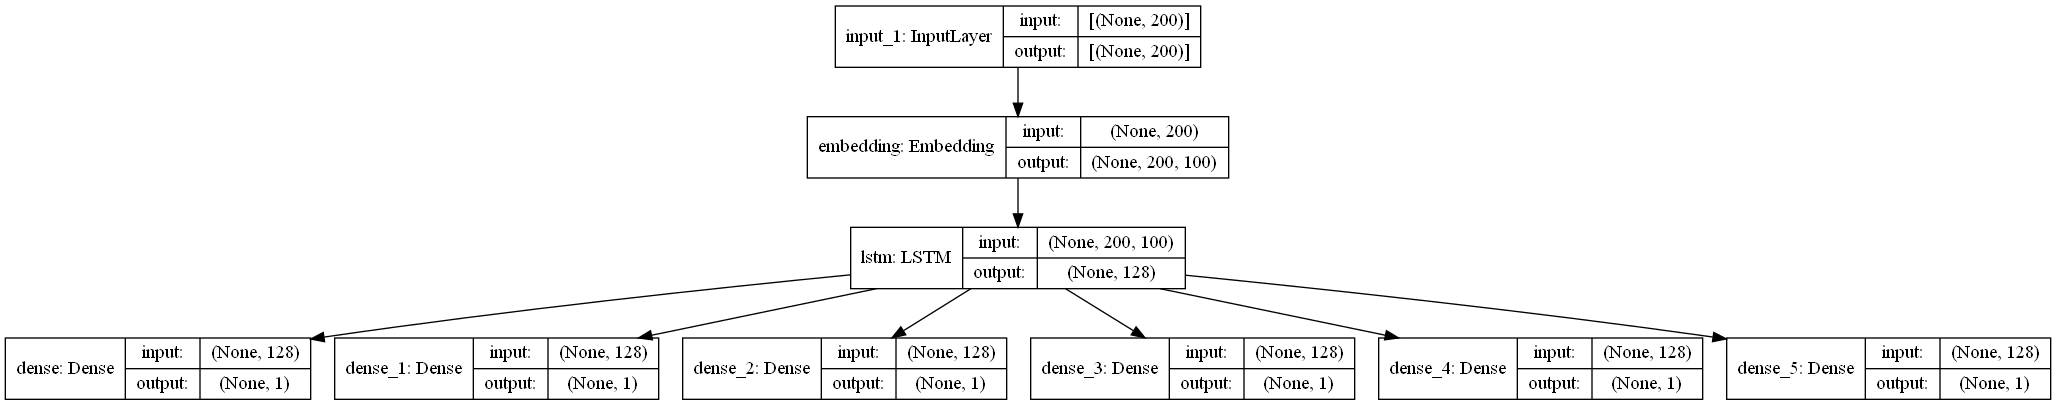

In [41]:
##
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
from keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [34]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

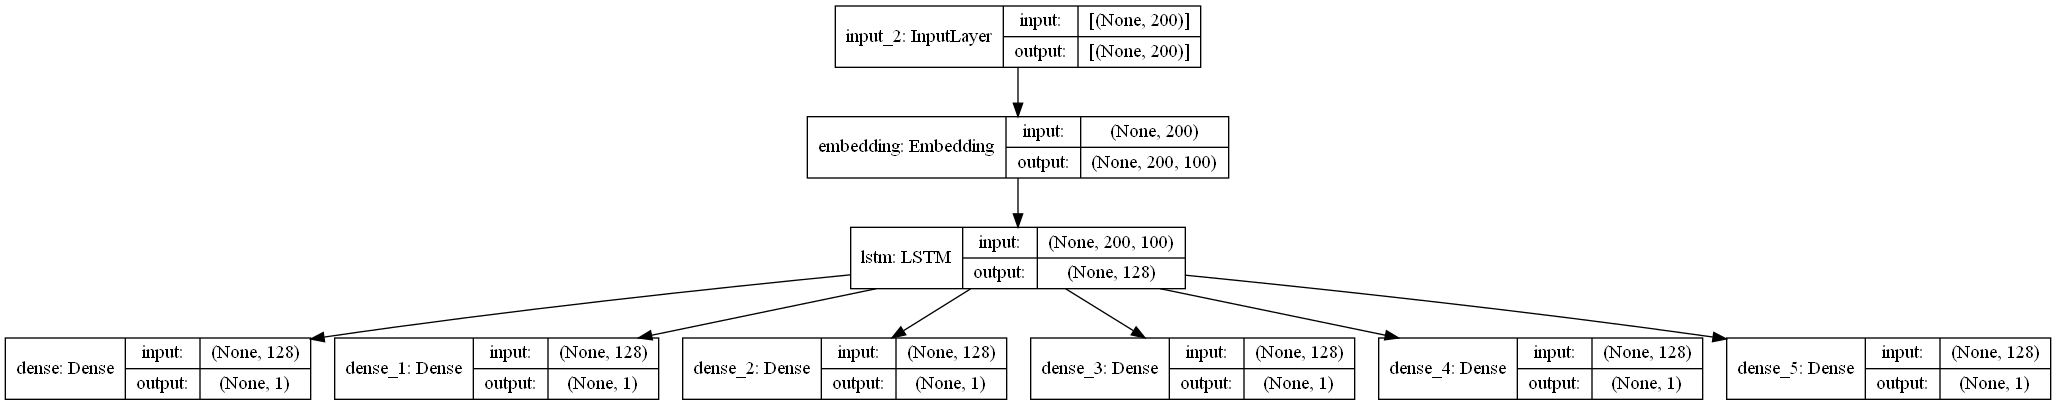

In [27]:
# history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

In [4]:
def encoding(string):
    no = len(string)
    i = 0
    while i < no- 1:
        cnt = 1
        while (i < no - 1 and
               string[i] == string[i + 1]):
            cnt += 1
            i += 1
        i += 1
 
        print(string[i - 1] + str(cnt),end = "")
        

In [5]:
st='bbcceeee'
encoding(st)

b2c2e4